In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import itertools
from constants import *
from submodels import *
from functions import *

In [2]:
df_train = pd.read_csv("split/train.csv").rename(name_remap, axis=1)
df_dev = pd.read_csv("split/dev.csv").rename(name_remap, axis=1)

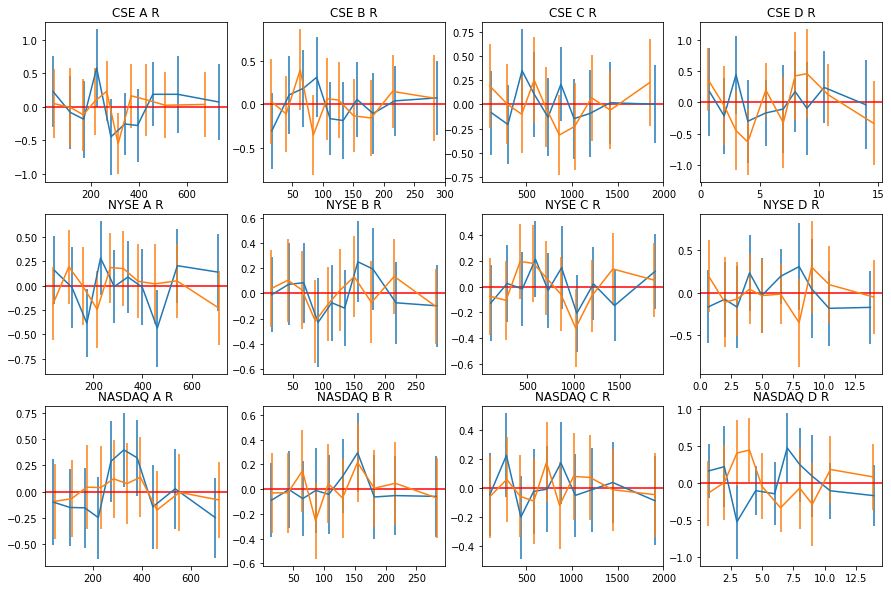

In [52]:
fig, axs = plt.subplots(3, 4)

retail_line = {}

for i, j in itertools.product(range(len(exchanges)), range(len(stocks))):
    xchg = exchanges[i]
    stk = stocks[j]
    # part = parties[k]
    part = 'R'

    df = df_train[(df_train.xchg == xchg) & (df_train.stk == stk) & (df_train.cp == part)]

    buy_trap = trapezoids[(xchg, stk, "B")]
    sell_trap = trapezoids[(xchg, stk, "S")]

    buy_df = df[df.dir == "B"]
    sell_df = df[df.dir == "S"]

    if xchg == "NASDAQ" and stk == "B":
        # Kill the outlier!
        buy_df = buy_df[buy_df.sz != 487]

    if xchg == "CSE" and stk == "A":
        # Kill the outlier!
        sell_df = sell_df[sell_df.sz < 1000]

    buy_xs = buy_df.sz
    buy_ys = (buy_df.real_edge - buy_df.pred_edge) - np.array([buy_trap.calc(x) for x in buy_df.sm.values])

    sell_xs = sell_df.sz
    sell_ys = (sell_df.real_edge - sell_df.pred_edge) - np.array([sell_trap.calc(x) for x in sell_df.sm.values])

    buy_A = np.vstack([buy_xs.values, np.ones(len(buy_xs))]).T
    sell_A = np.vstack([sell_xs.values, np.ones(len(sell_xs))]).T

    buy_slope, buy_offset = np.linalg.lstsq(buy_A, buy_ys.values, rcond=None)[0]
    sell_slope, sell_offset = np.linalg.lstsq(sell_A, sell_ys.values, rcond=None)[0]

    retail_line[(xchg, stk, "B")] = {"slope": buy_slope, "offset": buy_offset}
    retail_line[(xchg, stk, "S")] = {"slope": sell_slope, "offset": sell_offset}

    # ys = df.real_edge - df.pred_edge
    binned_plot(buy_xs, buy_ys - buy_offset - buy_xs * buy_slope, 10, axs[i][j])
    binned_plot(sell_xs, sell_ys - sell_offset - sell_xs * sell_slope, 10, axs[i][j])

    axs[i][j].set_title(f"{xchg} {stk} {part}")
    axs[i][j].axhline(0, c='r')

    """
    df = df_train[(df_train.xchg == xchg) & (df_train.stk == stk) & (df_train.cp == part) & (df_train.dir == 'S')]
    ys = df.real_edge - df.pred_edge
    # ys = pd.Series([df.real_edge.iloc[k] - df.pred_edge.iloc[k] - trap.calc(df.sm.iloc[k]) for k in range(len(df))])
    # ys.index = df.sm.index
    binned_plot(df.sm, ys, 40, axs[i][j])
    axs[i][j].set_title(f"{xchg} {stk} {part}")
    axs[i][j].axhline(0, c='r')
    """

fig.set_size_inches(15, 10)

/home/kobortor/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/kobortor/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


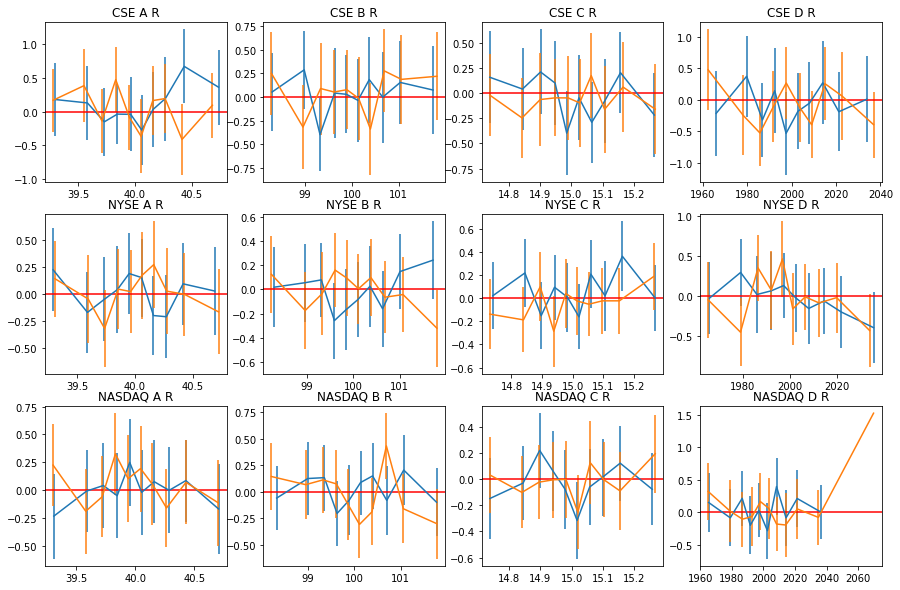

In [8]:
from submodels import *
fig, axs = plt.subplots(3, 4)

for i, j in itertools.product(range(len(exchanges)), range(len(stocks))):
    xchg = exchanges[i]
    stk = stocks[j]
    # part = parties[k]
    part = 'R'

    df = df_train[(df_train.xchg == xchg) & (df_train.stk == stk) & (df_train.cp == part)]

    buy_trap = trapezoids[(xchg, stk, "B")]
    sell_trap = trapezoids[(xchg, stk, "S")]

    buy_df = df[df.dir == "B"]
    sell_df = df[df.dir == "S"]

    if xchg == "NASDAQ" and stk == "B":
        # Kill the outlier!
        buy_df = buy_df[buy_df.sz != 487]

    if xchg == "CSE" and stk == "A":
        # Kill the outlier!
        sell_df = sell_df[sell_df.sz < 1000]

    buy_slope = retail_lines['slope'][(xchg, stk, "B")]
    buy_offset = retail_lines['offset'][(xchg, stk, "B")]

    sell_slope = retail_lines['slope'][(xchg, stk, "S")]
    sell_offset = retail_lines['offset'][(xchg, stk, "S")]

    buy_xs = buy_df.sz
    buy_ys = (buy_df.real_edge - buy_df.pred_edge)
    buy_ys -= np.array([buy_trap.calc(x) for x in buy_df.sm.values])
    buy_ys -= buy_offset + buy_slope * buy_xs

    sell_xs = sell_df.sz
    sell_ys = (sell_df.real_edge - sell_df.pred_edge)
    sell_ys -= np.array([sell_trap.calc(x) for x in sell_df.sm.values])
    sell_ys -= sell_offset + sell_slope * sell_xs

    # ys = df.real_edge - df.pred_edge
    binned_plot(buy_df.px, buy_ys, 10, axs[i][j])
    binned_plot(sell_df.px, sell_ys, 10, axs[i][j])

    axs[i][j].set_title(f"{xchg} {stk} {part}")
    axs[i][j].axhline(0, c='r')

    """
    df = df_train[(df_train.xchg == xchg) & (df_train.stk == stk) & (df_train.cp == part) & (df_train.dir == 'S')]
    ys = df.real_edge - df.pred_edge
    # ys = pd.Series([df.real_edge.iloc[k] - df.pred_edge.iloc[k] - trap.calc(df.sm.iloc[k]) for k in range(len(df))])
    # ys.index = df.sm.index
    binned_plot(df.sm, ys, 40, axs[i][j])
    axs[i][j].set_title(f"{xchg} {stk} {part}")
    axs[i][j].axhline(0, c='r')
    """

fig.set_size_inches(15, 10)

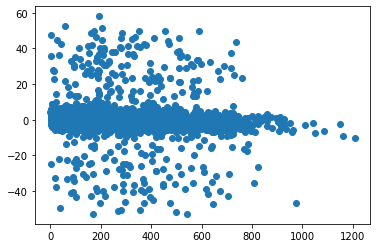

In [41]:
buy_trap = trapezoids[("CSE", "A", "S")]
df = df_train[(df_train.xchg == "CSE") & (df_train.stk == "A") & (df_train.cp == "R")]
plt.scatter(df.sz, df.real_edge - df.pred_edge - np.array([buy_trap.calc(x) for x in df.sm.values]))

In [51]:
df = pd.DataFrame.from_dict(retail_line).T
df.index = df.index.rename(['xchg', 'stk', 'dir'])
df.to_csv("retail_line.csv")

In [13]:
ys

50       -12.451942
73        -7.729445
258      -10.942035
273      -10.180757
319       -7.230401
            ...    
179514   -11.286482
179571   -27.829768
179744   -28.981707
179778   -10.471989
179806   -34.800539
Length: 2588, dtype: float64